In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [4]:
df = pd.read_csv("/Users/arsh/Downloads/Loan Approval Categorical Synthetic Dataset.csv")

In [6]:
df

,Unnamed: 0,Credit_History,Income_Level,Loan_Amount,Zip_Code,Education_Level,Approval_Prob,Loan_Approval
0,0,Fair,Low,Small,Suburban,High School,0.545770,Approved
1,1,Good,Low,Large,Urban,High School,0.582107,Approved
2,2,Good,Low,Medium,Rural,High School,0.646670,Approved
3,3,Fair,Medium,Medium,Urban,High School,0.379236,Disapproved
4,4,Bad,Medium,Medium,Suburban,High School,0.633403,Approved
...,...,...,...,...,...,...,...,...
9995,9995,Good,High,Small,Suburban,Bachelor,0.905898,Approved
9996,9996,Good,Low,Small,Suburban,High School,0.635281,Approved
9997,9997,Good,Low,Large,Urban,Master,0.662883,Approved
9998,9998,Fair,Medium,Medium,Urban,Bachelor,0.320122,Disapproved


In [8]:
df = df.drop(df.columns[[0, -1]], axis=1)

In [10]:
df

,Credit_History,Income_Level,Loan_Amount,Zip_Code,Education_Level,Approval_Prob
0,Fair,Low,Small,Suburban,High School,0.545770
1,Good,Low,Large,Urban,High School,0.582107
2,Good,Low,Medium,Rural,High School,0.646670
3,Fair,Medium,Medium,Urban,High School,0.379236
4,Bad,Medium,Medium,Suburban,High School,0.633403
...,...,...,...,...,...,...
9995,Good,High,Small,Suburban,Bachelor,0.905898
9996,Good,Low,Small,Suburban,High School,0.635281
9997,Good,Low,Large,Urban,Master,0.662883
9998,Fair,Medium,Medium,Urban,Bachelor,0.320122


In [12]:
features = ["Credit_History", "Income_Level", "Loan_Amount", "Zip_Code", "Education_Level"]
target   = "Approval_Prob"  # now continuous




In [14]:
train_df, test_df = train_test_split(
    df, test_size=0.3, random_state=42)


In [16]:
X_test_orgin = test_df.copy()

In [18]:
X_test_orgin

,Credit_History,Income_Level,Loan_Amount,Zip_Code,Education_Level,Approval_Prob
6252,Fair,Low,Small,Suburban,Bachelor,0.501679
4684,Good,Medium,Large,Suburban,Bachelor,0.452133
1731,Fair,Low,Small,Suburban,High School,0.369745
4742,Bad,High,Large,Urban,Master,0.367556
4521,Fair,High,Medium,Rural,Bachelor,0.706402
...,...,...,...,...,...,...
8014,Fair,Low,Small,Suburban,Bachelor,0.497551
1074,Good,Low,Large,Suburban,Bachelor,0.328491
3063,Fair,High,Medium,Urban,High School,0.624640
6487,Fair,Medium,Medium,Suburban,Master,0.519299


In [20]:
mappings = {
    "Credit_History":   {"Bad": 0, "Fair": 1, "Good": 2},
    "Income_Level":     {"Low": 0, "Medium": 1, "High": 2},
    "Loan_Amount":      {"Small": 2, "Medium": 1, "Large": 0},
    "Zip_Code":         {"Urban": 0, "Suburban": 1, "Rural": 2},
    "Education_Level":  {"High School": 0, "Bachelor": 1, "Master": 2}
}

In [22]:
for col, map_dict in mappings.items():
    train_df[col] = train_df[col].map(map_dict)
    test_df[col]  = test_df[col].map(map_dict)

In [24]:
class CatRegDataset(Dataset):
    def __init__(self, df, feature_cols, target_col):
        self.X = torch.LongTensor(df[feature_cols].values)
        self.y = torch.FloatTensor(df[target_col].values).unsqueeze(1)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [38]:
X_train = train_df[features].values
y_train = train_df[target].values
X_test  = test_df[features].values
y_test  = test_df[target].values

In [26]:
train_ds = CatRegDataset(train_df, features, target)
test_ds  = CatRegDataset(test_df,  features, target)
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
test_dl  = DataLoader(test_ds,  batch_size=4)

In [28]:
class TabularTransformerReg(nn.Module):
    def __init__(self, cat_dims, d_model=16, nhead=4, num_layers=2):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(n, d_model) for n in cat_dims])
        self.pos    = nn.Parameter(torch.randn(len(cat_dims), d_model))
        enc_layer   = nn.TransformerEncoderLayer(d_model, nhead)
        self.trans  = nn.TransformerEncoder(enc_layer, num_layers)
        self.reg    = nn.Linear(d_model, 1)

    def forward(self, x):
        embs = [emb(x[:, i]) for i, emb in enumerate(self.embeds)]
        seq  = torch.stack(embs, dim=1)            # [B, F, d_model]
        seq  = seq + self.pos.unsqueeze(0)         # add positional embeddings
        seq  = seq.permute(1, 0, 2)                # [F, B, d_model]
        out  = self.trans(seq)                     # [F, B, d_model]
        rep  = out.permute(1, 0, 2).mean(dim=1)     # [B, d_model]
        return self.reg(rep)                       # [B, 1]


In [30]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model   = TabularTransformerReg(cat_dims=[3,3,3,3,3]).to(device)
opt     = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [32]:
for epoch in range(1, 21):
    model.train()
    total_loss = 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        pred   = model(xb)
        loss   = loss_fn(pred, yb)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item() * xb.size(0)
    if epoch % 10 == 0:
        print(f"Epoch {epoch:02d}  train MSE = {total_loss/len(train_dl.dataset):.4f}")


Epoch 10  train MSE = 0.0193
Epoch 20  train MSE = 0.0190


In [34]:
model.eval()
y_preds, y_trues = [], []
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        preds = model(xb).cpu().numpy().flatten()
        y_preds.extend(preds)
        y_trues.extend(yb.numpy().flatten())


In [41]:
preds_df = pd.DataFrame({"pred_value": y_preds})


In [43]:
mse = mean_squared_error(y_trues, y_preds)
r2  = r2_score(y_trues, y_preds)
print(f"\nTest MSE: {mse:.4f}")
print(f"Test R² : {r2:.4f}")


Test MSE: 0.0190
Test R² : 0.5696


In [47]:
true_labels = X_test_orgin["Approval_Prob"].values 

In [60]:
X_test_orgin

,Credit_History,Income_Level,Loan_Amount,Zip_Code,Education_Level,Approval_Prob
6252,Fair,Low,Small,Suburban,Bachelor,0.501679
4684,Good,Medium,Large,Suburban,Bachelor,0.452133
1731,Fair,Low,Small,Suburban,High School,0.369745
4742,Bad,High,Large,Urban,Master,0.367556
4521,Fair,High,Medium,Rural,Bachelor,0.706402
...,...,...,...,...,...,...
8014,Fair,Low,Small,Suburban,Bachelor,0.497551
1074,Good,Low,Large,Suburban,Bachelor,0.328491
3063,Fair,High,Medium,Urban,High School,0.624640
6487,Fair,Medium,Medium,Suburban,Master,0.519299


In [62]:
test_df = X_test_orgin.drop(X_test_orgin.columns[[-1]], axis=1)

In [64]:
merged_df = pd.concat([
    test_df.reset_index(drop=True),
    preds_df.reset_index(drop=True)
], axis=1)

In [66]:
merged_df

,Credit_History,Income_Level,Loan_Amount,Zip_Code,Education_Level,pred_value
0,Fair,Low,Small,Suburban,Bachelor,0.546841
1,Good,Medium,Large,Suburban,Bachelor,0.503365
2,Fair,Low,Small,Suburban,High School,0.554159
3,Bad,High,Large,Urban,Master,0.355897
4,Fair,High,Medium,Rural,Bachelor,0.635739
...,...,...,...,...,...,...
2995,Fair,Low,Small,Suburban,Bachelor,0.546841
2996,Good,Low,Large,Suburban,Bachelor,0.392775
2997,Fair,High,Medium,Urban,High School,0.630264
2998,Fair,Medium,Medium,Suburban,Master,0.507347


In [68]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.formula.api as smf

In [86]:
def one_way_anova_with_eta(df, feature, target="Prediction"):
    formula = f"{target} ~ C({feature})"
    model = ols(formula, data=df).fit()
    anova_table = anova_lm(model, typ=2)

    sum_sq_factor = anova_table.loc[f"C({feature})", "sum_sq"]
    sum_sq_total = anova_table["sum_sq"].sum()
    F_stat = anova_table.loc[f"C({feature})", "F"]
    p_value = anova_table.loc[f"C({feature})", "PR(>F)"]
    eta_sq = sum_sq_factor / sum_sq_total if sum_sq_total > 0 else 0.0
    return F_stat, p_value, eta_sq

# 2) Features of interest
features = ["Credit_History", "Income_Level", "Loan_Amount", "Zip_Code", "Education_Level"]

In [88]:
# features = ["Credit_History", "Income_Level", 
#             "Loan_Amount", "Zip_Code", "Education_Level"]

In [90]:
results = []
for feat in features:
    F, pval, eta_sq = one_way_anova_with_eta(merged_df, feat, target="pred_value")
    results.append({
        "Feature": feat,
        "F_stat": F,
        "Eta_squared": eta_sq,
        "p_value": pval
    })

In [92]:
res_df = pd.DataFrame(results)
sig_df = res_df[res_df["p_value"] < 0.05].copy()

# 5) Sort by effect size (η²) descending
sig_df.sort_values("Eta_squared", ascending=False, inplace=True)
sig_df.reset_index(drop=True, inplace=True)

# 6) Display significant results
print("Significant Features (p < 0.05), ranked by η²:\n")
print(sig_df[["Feature", "F_stat", "p_value", "Eta_squared"]])


Significant Features (p < 0.05), ranked by η²:

           Feature       F_stat        p_value  Eta_squared
0      Loan_Amount  1058.789224   0.000000e+00     0.414028
1   Credit_History   741.746716  2.010506e-262     0.331100
2     Income_Level   468.825183  7.050553e-178     0.238306
3  Education_Level     5.698596   3.387077e-03     0.003788


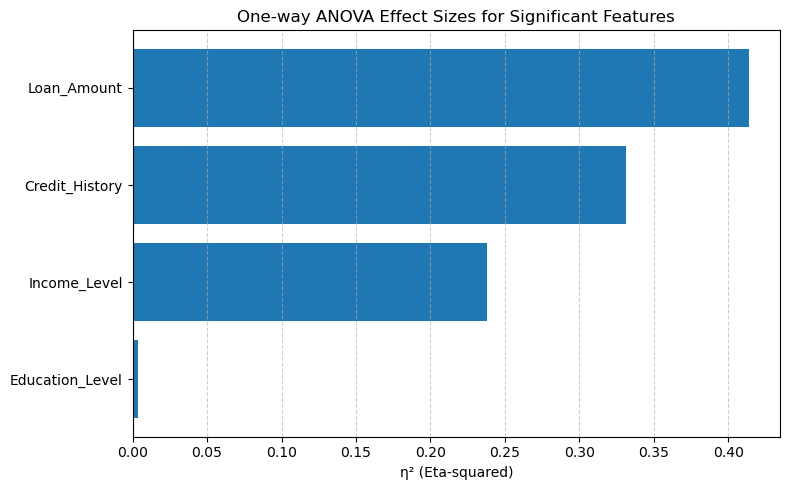

In [98]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.barh(sig_df["Feature"], sig_df["Eta_squared"])
plt.xlabel("η² (Eta-squared)")
plt.title("One-way ANOVA Effect Sizes for Significant Features")
plt.gca().invert_yaxis()  # largest η² on top
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [100]:
def compute_feature_recovery_metrics(gt, ranking):
    """
    Compute TP, FP, FN, Precision, Recall, FDR, and Top-1 Match for feature recovery.

    Parameters
    ----------
    gt : set
        Ground-truth causal features.
    flagged : list or set
        Features your method flagged as important (e.g., top‑k from ranking).
    ranking : list
        Ordered list of features by descending effect size.

    Returns
    -------
    pd.DataFrame
        Single-row DataFrame with the metrics.
    """
    tp = set(gt) & set(ranking)
    fp = set(ranking) - set(gt)
    fn = set(gt) - set(ranking)

    precision = len(tp) / (len(tp) + len(fp)) if (len(tp) + len(fp)) else 0.0
    recall    = len(tp) / len(gt)        if len(gt)              else 0.0
    fdr       = len(fp) / (len(tp) + len(fp)) if (len(tp) + len(fp)) else 0.0
    top1      = 1 if ranking and ranking[0] in gt else 0

    metrics = {
        "TP":           ", ".join(sorted(tp)),
        "FP":           ", ".join(sorted(fp)),
        "FN":           ", ".join(sorted(fn)),
        "Precision":     precision,
        "Recall":        recall,
        "FDR":           fdr,
        "Top-1 Match":   top1
    }
    return pd.DataFrame([{
        "Precision": precision,
        "Recall": recall,
        "FDR": fdr,
        "Top-1 Match": top1
    }])



if __name__ == "__main__":
    # Example:
    GT = {"Loan_Amount", "Credit_History", "Income_Level"}
    ranking = [
        "Loan_Amount",
        "Credit_History",
        "Income_Level",
        "Education_Level",
    ]
    # flagged = ranking[:3]  # e.g. top‑3 features

    df_metrics = compute_feature_recovery_metrics(GT, ranking)
    df_metrics.insert(0, "Method", "Stat-XAI")
    df_metrics = df_metrics[["Method", "Precision", "Recall", "FDR", "Top-1 Match"]]
    print(df_metrics.to_string(index=False))

  Method  Precision  Recall  FDR  Top-1 Match
Stat-XAI       0.75     1.0 0.25            1


In [36]:
import shap
import numpy as np
import psutil
import os
import torch.optim as optim
import matplotlib.pyplot as plt

In [40]:
def predict_proba_np(x_np):
    """
    x_np: np.array of shape (batch, 5), dtype int
    returns: np.array of shape (batch,) with predicted positive‐class probabilities
    """
    model.eval()
    with torch.no_grad():
        tensor = torch.LongTensor(x_np).to(device)
        logits = model(tensor)
        probs  = torch.sigmoid(logits).cpu().numpy().flatten()
    return probs

In [42]:
bg_size    = 100
bg_idx     = np.random.choice(len(X_train), size=bg_size, replace=False)
background = X_train[bg_idx] 

In [44]:
explainer = shap.KernelExplainer(predict_proba_np, background)



In [46]:
batch_size = 512
all_shap   = []

In [48]:
for start in range(0, len(X_test), batch_size):
    end    = min(start + batch_size, len(X_test))
    Xb_np  = X_test[start:end]
    
    mem = psutil.virtual_memory()
    print(f"Batch {start}-{end}: free RAM {mem.available/1e9:.2f} GB")
    
    # nsamples controls speed/accuracy
    shap_vals_batch = explainer.shap_values(Xb_np, nsamples=100)
    all_shap.append(shap_vals_batch)


Batch 0-512: free RAM 3.56 GB


  0%|          | 0/512 [00:00<?, ?it/s]

Batch 512-1024: free RAM 3.68 GB


  0%|          | 0/512 [00:00<?, ?it/s]

Batch 1024-1536: free RAM 3.67 GB


  0%|          | 0/512 [00:00<?, ?it/s]

Batch 1536-2048: free RAM 3.73 GB


  0%|          | 0/512 [00:00<?, ?it/s]

Batch 2048-2560: free RAM 3.73 GB


  0%|          | 0/512 [00:00<?, ?it/s]

Batch 2560-3000: free RAM 3.77 GB


  0%|          | 0/440 [00:00<?, ?it/s]

In [50]:
all_shap_values = np.vstack(all_shap)

In [52]:
mean_abs = pd.Series(
    np.abs(all_shap_values).mean(axis=0),
    index=features
).sort_values()

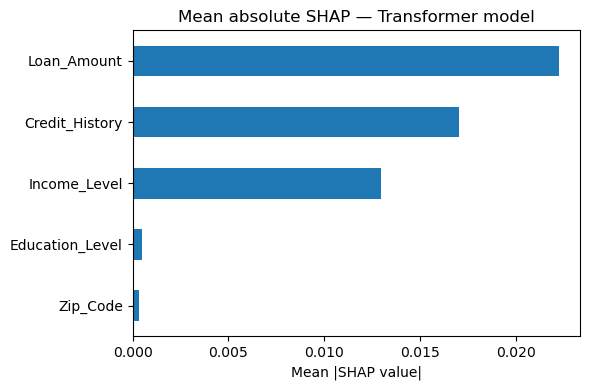

In [54]:
os.makedirs("shap", exist_ok=True)
plt.figure(figsize=(6,4))
mean_abs.plot.barh()
plt.xlabel("Mean |SHAP value|")
plt.title("Mean absolute SHAP — Transformer model")
plt.tight_layout()
plt.savefig("shap/Transformer_categorical_continous_shap_summary.jpg", dpi=300)
plt.show()

In [56]:
def compute_feature_recovery_metrics(gt, ranking):
    """
    Compute TP, FP, FN, Precision, Recall, FDR, and Top-1 Match for feature recovery.

    Parameters
    ----------
    gt : set
        Ground-truth causal features.
    flagged : list or set
        Features your method flagged as important (e.g., top‑k from ranking).
    ranking : list
        Ordered list of features by descending effect size.

    Returns
    -------
    pd.DataFrame
        Single-row DataFrame with the metrics.
    """
    tp = set(gt) & set(ranking)
    fp = set(ranking) - set(gt)
    fn = set(gt) - set(ranking)

    precision = len(tp) / (len(tp) + len(fp)) if (len(tp) + len(fp)) else 0.0
    recall    = len(tp) / len(gt)        if len(gt)              else 0.0
    fdr       = len(fp) / (len(tp) + len(fp)) if (len(tp) + len(fp)) else 0.0
    top1      = 1 if ranking and ranking[0] in gt else 0

    metrics = {
        "TP":           ", ".join(sorted(tp)),
        "FP":           ", ".join(sorted(fp)),
        "FN":           ", ".join(sorted(fn)),
        "Precision":     precision,
        "Recall":        recall,
        "FDR":           fdr,
        "Top-1 Match":   top1
    }
    return pd.DataFrame([{
        "Precision": precision,
        "Recall": recall,
        "FDR": fdr,
        "Top-1 Match": top1
    }])


In [58]:
if __name__ == "__main__":
    # Example:
    GT = {"Loan_Amount", "Credit_History", "Income_Level"}
    ranking = [
        "Loan_Amount",
        "Credit_History",
        "Income_Level",
    "Education_Level",
    "Zip_Code"]
    # flagged = ranking[:3]  # e.g. top‑3 features

    df_metrics = compute_feature_recovery_metrics(GT, ranking)
    df_metrics.insert(0, "Method", "SHAP-XAI")
    df_metrics = df_metrics[["Method", "Precision", "Recall", "FDR", "Top-1 Match"]]
    print(df_metrics.to_string(index=False))

  Method  Precision  Recall  FDR  Top-1 Match
SHAP-XAI        0.6     1.0  0.4            1
